In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# First generate a random hamiltonian of the Huckel model
# i.e. alpha on the diagonal, and beta on the off-diagonals to represent nearest neighbors
#    for now use random alpha and beta
np.random.seed(2)
alpha = np.random.random()
beta = np.random.random()

# define the dimensions of the Hamiltonian and how many elements to consider before cutoff
size = 50
n_cutoff = 9
H = pals.generate_H(n_cutoff, size, beta, alpha)
H_spect = linalg.eigvalsh(H)

# define a chemical potential mu (middle of eigenvalue spectrum)
num_electrons = int(0.5*H.shape[0])
mu = (H_spect[num_electrons] + H_spect[num_electrons-1])/2

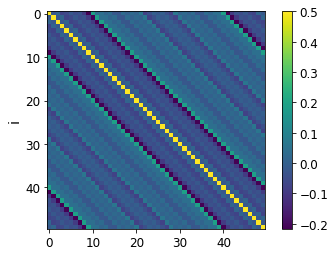

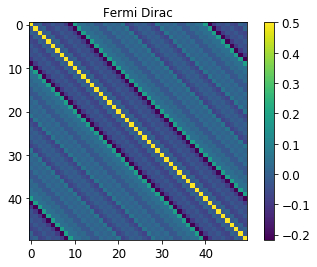

In [4]:
# Exact answers using Heaviside step function and Fermi-dirac statistics
# Heaviside - this simulates 0 tempurature

heav_exact = linalg.funm(H, lambda _: _ <= mu)
plt.imshow(heav_exact.real)
#plt.title("Exact by Heaviside")
plt.ylabel("i")
plt.colorbar()
plt.show()

# Fermi-Dirac - this simulates infinite temperature
ferm_exact = linalg.funm(H, lambda _: 1/(1+np.exp(1000*(_ - mu))))
plt.imshow(ferm_exact.real)
plt.title("Fermi Dirac")
plt.colorbar()
plt.show()

GCP steps:  19
CP steps:  18
Idempt of GCP:  1.4772969479868097e-15
Idempt of CP:  5.4419646931649554e-15


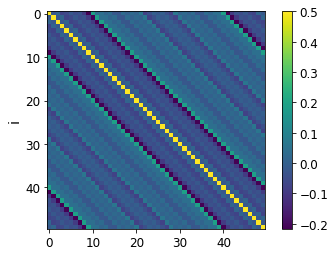

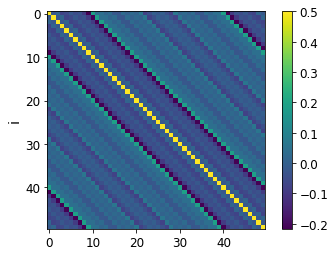

In [5]:
# Perform Palser GCP method
palser_gcp_rho = pals.gcp(mu, H, 100)
palser_gcp_energy = np.sum(palser_gcp_rho * H.T)

palser_cp_rho = pals.cp(num_electrons, H, 100)
palser_cp_energy = np.sum(palser_cp_rho * H.T)

print("Idempt of GCP: ", linalg.norm(palser_gcp_rho @ palser_gcp_rho - palser_gcp_rho))
print("Idempt of CP: ", linalg.norm(palser_cp_rho @ palser_cp_rho - palser_cp_rho))

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
#plt.title("Palser GCP")
#plt.xlabel("i")
plt.ylabel("i")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
#plt.title("Palser CP")
#plt.xlabel("i")
plt.ylabel("i")
plt.colorbar()

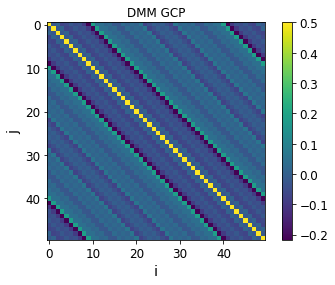

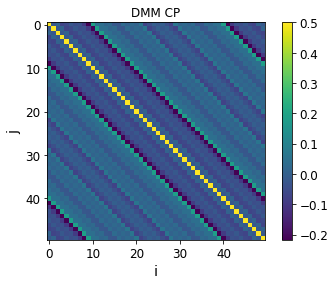

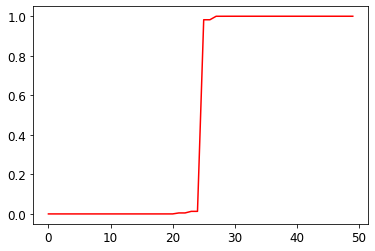

In [6]:
# perform our GCP and CP methods
dbeta = 0.1
ovlp = np.identity(H.shape[0], dtype=complex)
#inv_ovlp = linalg.inv(ovlp)
init_rho = ovlp/2

dmm_gcp_rho = gcp.rk4(gcp.rhs, init_rho, dbeta, H, ovlp, ovlp, mu, 10000)

init_rho = num_electrons/ovlp.trace() * ovlp
dmm_cp_rho = cp.rk4(cp.rhs, init_rho, dbeta, H, ovlp, ovlp, 10000)

plt.figure(1)
plt.imshow(dmm_gcp_rho.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp_rho.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(3)
plt.plot(linalg.eigvalsh(dmm_cp_rho), 'r-', label='cp_eigs')


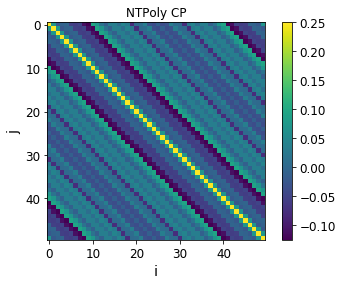

In [7]:
# perform method using NTPoly (Only CP for now)
ntpoly_cp_rho = nt.NTPoly_cp(H, ovlp, num_electrons)

plt.imshow(ntpoly_cp_rho.real)
plt.title("NTPoly CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

Idempt of GCP:  2.3792845503245633e-15
Idempt of CP:  0.3236985463085081


Text(0, 0.5, 'Population')

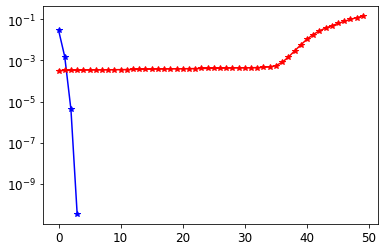

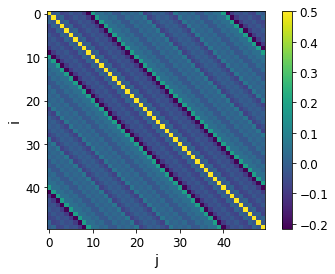

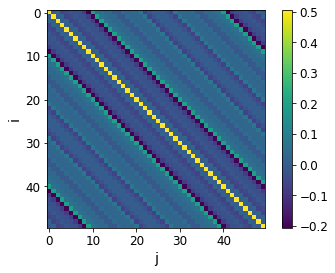

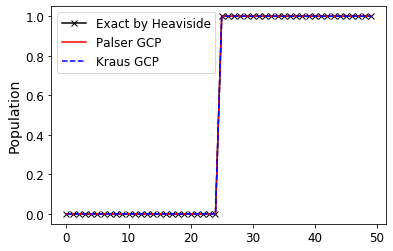

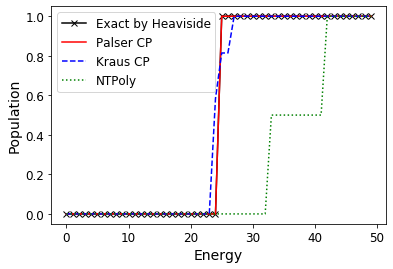

In [8]:
# "Naive" direct self-consistent iteration
func_args = {'h':H, 'mu': mu, 'inv_ovlp': ovlp}
gcp_rho = init_rho.copy()
gcp_norm_diff = []
for i in range(50):
    rho_next = gcp.steady_linear_single_step(gcp_rho, **func_args)
    rho_sq = rho_next @ rho_next
    rho_cu = rho_sq @ rho_next
    rho_next = 3*rho_sq - 2*rho_cu
    gcp_norm_diff.append(linalg.norm(rho_next - gcp_rho))
    gcp_rho = rho_next
    if gcp_norm_diff[-1] < 1e-10:
        break

cp_rho = init_rho.copy()
cp_norm_diff = []
for i in range(50):
    func_args['mu'] = cp.get_mu(cp_rho, H, ovlp)
    rho_next = gcp.steady_linear_single_step(cp_rho, **func_args)
    cp_norm_diff.append(linalg.norm(rho_next - cp_rho))
    cp_rho = rho_next
    if cp_norm_diff[-1] < 1e-10:
        break        
        
rho_sq = cp_rho @ cp_rho
rho_cu = rho_sq @ cp_rho
cp_rho = 3*rho_sq - 2*rho_cu

print("Idempt of GCP: ", linalg.norm(gcp_rho @ gcp_rho - gcp_rho))
print("Idempt of CP: ", linalg.norm(cp_rho @ cp_rho - cp_rho))
plt.figure(1)
plt.semilogy(gcp_norm_diff, 'b*-')
plt.semilogy(cp_norm_diff, 'r*-')

plt.figure(2)
plt.imshow(gcp_rho.real)
plt.ylabel("i")
plt.xlabel("j")
plt.colorbar()

plt.figure(3)
plt.imshow(cp_rho.real)
plt.ylabel("i")
plt.xlabel("j")
plt.colorbar()

plt.figure(4)
plt.plot(linalg.eigvalsh(heav_exact), 'kx-', label="Exact by Heaviside")
plt.plot(linalg.eigvalsh(palser_gcp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(gcp_rho), 'b--', label="Kraus GCP")
plt.legend(numpoints=1)
plt.ylabel("Population")

plt.figure(5)
plt.plot(linalg.eigvalsh(heav_exact), 'kx-', label="Exact by Heaviside")
plt.plot(linalg.eigvalsh(palser_cp_rho), 'r-', label="Palser CP")
plt.plot(linalg.eigvalsh(cp_rho), 'b--', label="Kraus CP")
plt.plot(linalg.eigvalsh(ntpoly_cp_rho), 'g:', label="NTPoly")
plt.legend(numpoints=1)
plt.xlabel("Energy")
plt.ylabel("Population")

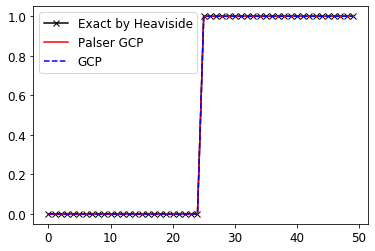

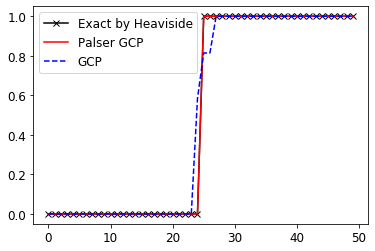

In [9]:
plt.figure(1)
plt.plot(linalg.eigvalsh(heav_exact), 'kx-', label="Exact by Heaviside")
plt.plot(linalg.eigvalsh(palser_gcp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(gcp_rho), 'b--', label="GCP")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(linalg.eigvalsh(heav_exact), 'kx-', label="Exact by Heaviside")
plt.plot(linalg.eigvalsh(palser_cp_rho), 'r-', label="Palser CP")
plt.plot(linalg.eigvalsh(cp_rho), 'b--', label="CP")
plt.legend(numpoints=1)


0.0


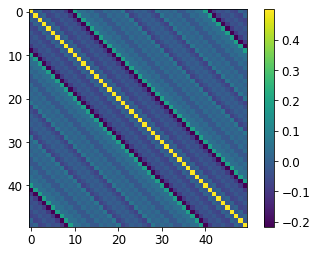

In [10]:
# First order Kraus operator method - slower than RK4
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.1
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ H
B += B.conj().T
B/= 2
print(linalg.norm(B - B.conj().T))
for i in range(10000):
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    
    K = -dbeta/2 * (iden - A) @ (B - mu*iden)
    Kdag = -dbeta/2 * (B - mu*iden) @ (iden - A)
    
    rho_next = (iden + Kdag) @ rho_i @ (iden + K)
    herm_check.append(linalg.norm(rho_next - rho_next.conj().T))
    trace_check.append(rho_next.trace())
    rho_i = rho_next.copy()
    
plt.imshow(rho_i.real)
plt.colorbar()
kraus_gcp = rho_i.copy()

0.0


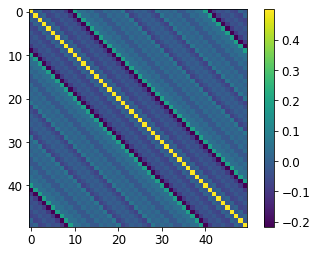

In [11]:
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.1
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ H
B += B.conj().T
B/= 2
print(linalg.norm(B - B.conj().T))
for i in range(10000):
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    
    cp.get_mu(rho_i, H, ovlp)
    K = -dbeta/2 * (iden - A) @ (B - mu*iden)
    Kdag = -dbeta/2 * (B - mu*iden) @ (iden - A)
    
    rho_next = (iden + Kdag) @ rho_i @ (iden + K)
    herm_check.append(linalg.norm(rho_next - rho_next.conj().T))
    trace_check.append(rho_next.trace())
    rho_i = rho_next.copy()
    
plt.imshow(rho_i.real)
plt.colorbar()
kraus_cp = rho_i.copy()

Text(0.5, 1.0, 'Norm Diff of Steady State')

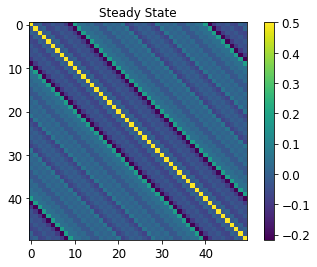

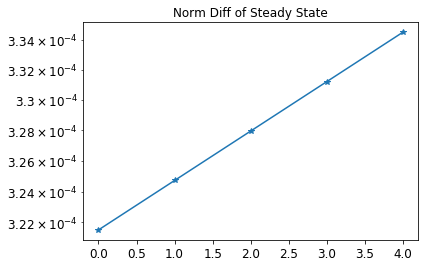

In [12]:
# Steady state
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ H
Bdag = H @ inv_ovlp

norm_diff = []
for i in range(5):
    A = inv_ovlp @ rho_i
    Adag = rho_i @ inv_ovlp
    rho_next = (iden + Bdag) @ rho_i @ (iden + B) - Bdag @ rho_i @ B
    rho_next += Bdag @ Adag @ rho_i @ A @ B - (iden + Bdag @ Adag) @ rho_i @ (iden + A @ B)
    rho_next += 2 * mu * (rho_i @ A)
    rho_next /= (2*mu)
    
    norm_diff.append(linalg.norm(rho_next - rho_i))
    if norm_diff[-1] < 1e-10:
        break
    
    rho_i = rho_next.copy()

plt.figure(1)
plt.imshow(rho_i.real)
plt.title("Steady State")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.title("Norm Diff of Steady State")

Text(0, 0.5, 'i')

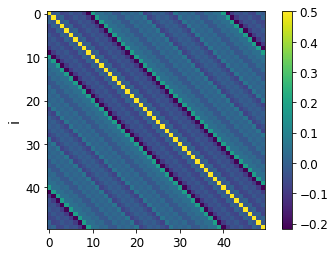

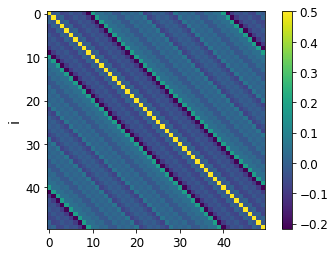

In [13]:
plt.figure(1)
plt.imshow(ferm_exact.real)
plt.colorbar()
plt.ylabel("i")

plt.figure(2)
plt.imshow(dmm_gcp_rho.real)
plt.colorbar()
plt.ylabel("i")
#plt.xlabel("j")

Text(0.5, 0, 'j')

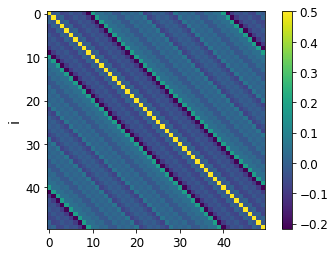

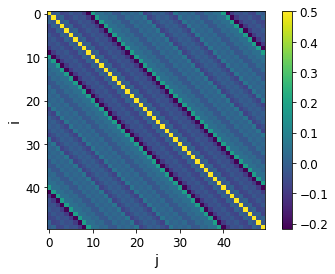

In [14]:
cp_mu = cp.get_mu(dmm_cp_rho, H, ovlp)

cp_ferm_exact = linalg.funm(H, lambda _: 1/(1+np.exp(100*(_ - cp_mu))))
cp_heav_exact = linalg.funm(H, lambda _: _ <= cp_mu)

plt.figure(1)
plt.imshow(ferm_exact.real)
plt.colorbar()
plt.ylabel("i")

plt.figure(2)
plt.imshow(dmm_cp_rho.real)
plt.colorbar()
plt.ylabel("i")
plt.xlabel("j")

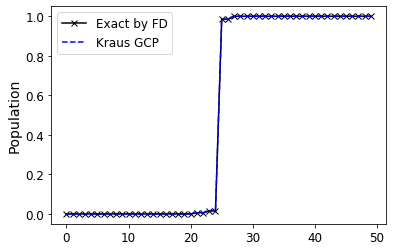

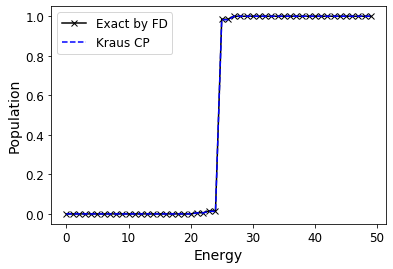

In [15]:
plt.figure(1)
plt.plot(linalg.eigvalsh(ferm_exact), 'k-x', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_gcp_rho), 'b--', label="Kraus GCP")
#plt.plot(linalg.eigvalsh(kraus_gcp), 'r--')
#plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(linalg.eigvalsh(ferm_exact), 'k-x', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_cp_rho), 'b--', label="Kraus CP")
#plt.plot(linalg.eigvalsh(kraus_cp), 'r--')
plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)


In [ ]:
plt.figure(1)
plt.plot(linalg.eigvalsh(rho_i), 'kx-', label="Steady")